# Introduction:
**We gonna analysis data set driven from supermarket which could help us in predicting <font color='blue'>items outlet sales</font> but we will firstly going through some data wrangling and cleaning as we work through we will be apple to build trusted model in predicting missing values of <font color='blue'>outlet size</font> also finding <font color='blue'> Item weight</font> missing values according to its <font color='blue'>Item Identifier</font>**

**Firstly,importing some libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

**Getting familiar with our data**

In [2]:
df = pd.read_csv('dd.csv') # Load data into a data-frame
df.index.name = 'ID'
df.head()  #getting overview of our data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
ID,,,,,,,,,,,,
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**It seems like we got some nominal and ordinal qualitative columns so we gonna store them for future usage also datatype seems to be fine**

In [3]:
label_cols = ['Item_Identifier','Item_Fat_Content','Item_Type'] #Storing Qualitatve Nominal features
ordinal_cols = ['Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type'] #Storing Qualitatve ordinal features
df.info() #Checking data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**We got 15% missing values from <font color='blue'>Item_Weight</font> and 22% from <font color='blue'>Outlet_Size</font> and that is more than just be ignored and dropped**

In [4]:
df.isnull().sum() #checking for null values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
print('Percentage of missing Item_Weight: ' +str((df['Item_Weight'].isnull().sum()/(df['Item_Weight'].isnull().sum()+df.shape[0]))*100)+'%')
print('Percentage of missing Outlet_Size: ' +str((df['Outlet_Size'].isnull().sum()/(df['Outlet_Size'].isnull().sum()+df.shape[0]))*100)+'%')

Percentage of missing Item_Weight: 14.650510715001003%
Percentage of missing Outlet_Size: 22.04335498033477%


**None duplicated rows**

In [6]:
check = pd.DataFrame(df,columns=df.columns)
duplicate = check[check.duplicated(keep='last')] #checking for duplicated rows  
duplicate

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
ID,,,,,,,,,,,,


**range of these two features seems to be fine**

In [7]:
#checking for any logical error in Item_Outlet_Sales  
print('max_sale: ' + str(df['Item_Outlet_Sales'].max()))
print('min_sale: ' + str(df['Item_Outlet_Sales'].min()))
print('max_year: ' + str(df['Outlet_Establishment_Year'].max()))
print('min_year: ' + str(df['Outlet_Establishment_Year'].min()))

max_sale: 13086.9648
min_sale: 33.29
max_year: 2009
min_year: 1985


**Found out that Item_Fat_Content has same element but described in different ways** 

In [8]:
#Getting an overview of unique elements in each feature
Columns = ['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']
for c in Columns:
    Uni = df[c].unique()
    print(' ')
    print (c)
    print (Uni)

 
Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
 
Item_Fat_Content
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
 
Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
 
Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
 
Outlet_Size
['Medium' nan 'High' 'Small']
 
Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']
 
Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


**Fixing Item_Fat_Content**

In [9]:
#Cleaning Item_Fat_Content from repetitve values
for i in range(len(df.index)):
    if df.loc[i,'Item_Fat_Content'] == 'low fat' or df.loc[i,'Item_Fat_Content'] == 'LF':
        df.loc[i,'Item_Fat_Content'] = 'Low Fat'
    elif df.loc[i,'Item_Fat_Content'] == 'reg': 
        df.loc[i,'Item_Fat_Content'] = 'Regular'
Uni = df['Item_Fat_Content'].unique()
Uni

array(['Low Fat', 'Regular'], dtype=object)

**There is an strong relation between Item_Weight and Item_Identifier so we can predict missing Item_Weight from Its Item_Identifier**

In [10]:
ed =df[["Item_Identifier", "Item_Weight"]]
ed = ed.set_index("Item_Identifier")
ed.head()
ed.loc['FDA15'] #Each Item_Identifier	Item_Weight

,Item_Weight
Item_Identifier,
FDA15,9.3
FDA15,9.3
FDA15,9.3
FDA15,9.3
FDA15,9.3
FDA15,9.3
FDA15,NaN
FDA15,9.3


In [11]:
for row in ed.itertuples():
    try:
        x = ed.at[row.Index, 'Item_Weight'].unique()[~np.isnan(ed.at[row.Index, 'Item_Weight'].unique())][0]
        df.loc[df['Item_Identifier'] == row.Index, 'Item_Weight'] = x
    except:
        pass   

**Now we left with only 0.047% missing values from <font color='blue'>Item_Weight</font> which can be easily dropped with no such effect**

In [12]:
print('Percentage of missing Item_Weight: ' +str((df['Item_Weight'].isnull().sum()/(df['Item_Weight'].isnull().sum()+df.shape[0]))*100)+'%')
df = df[df['Item_Weight'].notna()]

Percentage of missing Item_Weight: 0.04690981587897267%


In [13]:
df_copy = df.copy()#get a copy of our data-frame

In [14]:
#Qualitative Nominal encoding
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
df_copy =MultiColumnLabelEncoder(label_cols).fit_transform(df_copy)

**Class that will deal with Ordinal Qualitative values like Outlet_Size and will store a version for future decoding also can ignore and deal with nan values credits to https://github.com/idanhadromi/Modules/blob/main/Label_Encoder_contain_missing_values.ipynb**

In [15]:
#Qualitative ordinal encoding
class label_encoder_contain_missing_values :
    

    def __init__ (self) :    
            pass  

    def categorical_to_numeric (self,dataset):
        import numpy as np
        import pandas as pd
            
        self.dataset = dataset
        self.summary = None
        self.table_encoder= {}

        for index in self.dataset.columns :
            if self.dataset[index].dtypes == 'object' : 
                column_data_frame = pd.Series(self.dataset[index],name='column').to_frame()
                unique_values = pd.Series(self.dataset[index].unique())
                i = 0
                label_encoder = pd.DataFrame({'value_name':[],'Encode':[]})
                while i <= len(unique_values)-1:
                    if unique_values.isnull()[i] == True : 
                         label_encoder = label_encoder.append({'value_name': unique_values[i],'Encode':np.nan}, ignore_index=True)
                    else:
                        label_encoder = label_encoder.append({'value_name': unique_values[i],'Encode':i}, ignore_index=True)
                    i+=1 
                output = pd.merge(left=column_data_frame,right = label_encoder, how='left',left_on='column',right_on='value_name')
                self.summary = output[['column','Encode']].drop_duplicates().reset_index(drop=True)
                self.dataset[index] = output.Encode 
                self.table_encoder.update({index:self.summary})
            else :
                pass
        print('''\nLabel Encoding completed in Successfully.\n
                       Next steps: \n
                       1.  To view table_encoder, Execute the follow: \n
                           for index in table_encoder :
                           print(f'\\n{index} \\n',table_encoder[index])
                           
                       2. For inverse, execute the follow : \n
                          df = label_encoder_contain_missing_values().
                               inverse_numeric_to_categorical(table_encoder, df) ''')
        return self.table_encoder  ,self.dataset
    def inverse_numeric_to_categorical (self,table_encoder, df):
            dataset = df.copy()
            for column in table_encoder.keys():
                df_column = df[column].to_frame()
                output = pd.merge(left=df_column,right = table_encoder[column], how='left',left_on= column,right_on='Encode')#.rename(columns={'column_x' :'encode','column_y':'category'})
                df[column]= output.column
            print('\nInverse Label Encoding, from categorical to numerical completed in Successfully.\n')
            return df
        
table_encoder, df_copy = label_encoder_contain_missing_values().categorical_to_numeric(df_copy)    


Label Encoding completed in Successfully.

                       Next steps: 

                       1.  To view table_encoder, Execute the follow: 

                           for index in table_encoder :
                           print(f'\n{index} \n',table_encoder[index])
                           
                       2. For inverse, execute the follow : 

                          df = label_encoder_contain_missing_values().
                               inverse_numeric_to_categorical(table_encoder, df) 


In [16]:
df_copy.loc[df_copy['Outlet_Size'] > 0 , 'Outlet_Size'] -= 1
df_copy['Outlet_Size'].unique()

array([ 0., nan,  1.,  2.])

In [17]:
df_Outlet_Size = df_copy[df_copy['Outlet_Size'].isnull()] #Spliting data
df_copy.dropna(subset = ['Outlet_Size'], inplace=True)

In [18]:
df_Outlet_Size.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
ID,,,,,,,,,,,,
3,1117,19.200,1,0.000000,6,182.0950,2.0,1998,NaN,1.0,2.0,732.3800
8,439,16.200,1,0.016687,5,96.9726,5.0,2002,NaN,2.0,0.0,1076.5986
9,986,19.200,1,0.094450,5,187.8214,6.0,2007,NaN,2.0,0.0,4710.5350
25,1290,13.000,0,0.099887,9,45.9060,6.0,2007,NaN,2.0,0.0,838.9080
28,350,5.925,1,0.161467,4,45.5086,2.0,1998,NaN,1.0,2.0,178.4344


**As we can see from correlation table and graphs there is a strong linear relation between <font color='blue'>Outlet_Size</font> and two features of (<font color='brown'>Outlet_Identifier</font> , <font color='brown'>Outlet_Type</font>) also there is a relation between <font color='blue'>Item_Outlet_Sales</font> and (<font color='brown'>Item_MRP</font> , <font color='brown'>Item_Visibility</font>)**

In [19]:
corr = df_copy.corr()
corr.style.background_gradient(cmap='coolwarm')#correlation table

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,1.000000,0.048524,-0.099164,-0.024006,-0.018142,0.022225,-0.009970,-0.006818,-0.014660,-0.009083,0.013802,-0.006226
Item_Weight,0.048524,1.000000,-0.030167,-0.007601,0.030956,0.037123,-0.015123,-0.023795,-0.022801,0.004348,0.017744,0.026930
Item_Fat_Content,-0.099164,-0.030167,1.000000,0.043988,-0.136029,0.007029,-0.029902,-0.005694,-0.025512,-0.017272,-0.006412,0.016370
Item_Visibility,-0.024006,-0.007601,0.043988,1.000000,-0.034844,-0.000688,0.030652,-0.084770,0.025236,-0.041126,0.015746,-0.138120
Item_Type,-0.018142,0.030956,-0.136029,-0.034844,1.000000,0.037141,0.011817,0.007711,0.013700,0.012392,-0.008885,0.014995
Item_MRP,0.022225,0.037123,0.007029,-0.000688,0.037141,1.000000,0.012268,0.010514,0.017551,0.003239,-0.018816,0.564578
Outlet_Identifier,-0.009970,-0.015123,-0.029902,0.030652,0.011817,0.012268,1.000000,-0.017274,0.895859,0.181545,0.053575,-0.006480
Outlet_Establishment_Year,-0.006818,-0.023795,-0.005694,-0.084770,0.007711,0.010514,-0.017274,1.000000,-0.002293,0.036269,-0.045350,-0.052852
Outlet_Size,-0.014660,-0.022801,-0.025512,0.025236,0.013700,0.017551,0.895859,-0.002293,1.000000,0.078757,-0.373997,-0.021603
Outlet_Location_Type,-0.009083,0.004348,-0.017272,-0.041126,0.012392,0.003239,0.181545,0.036269,0.078757,1.000000,0.017720,0.032165


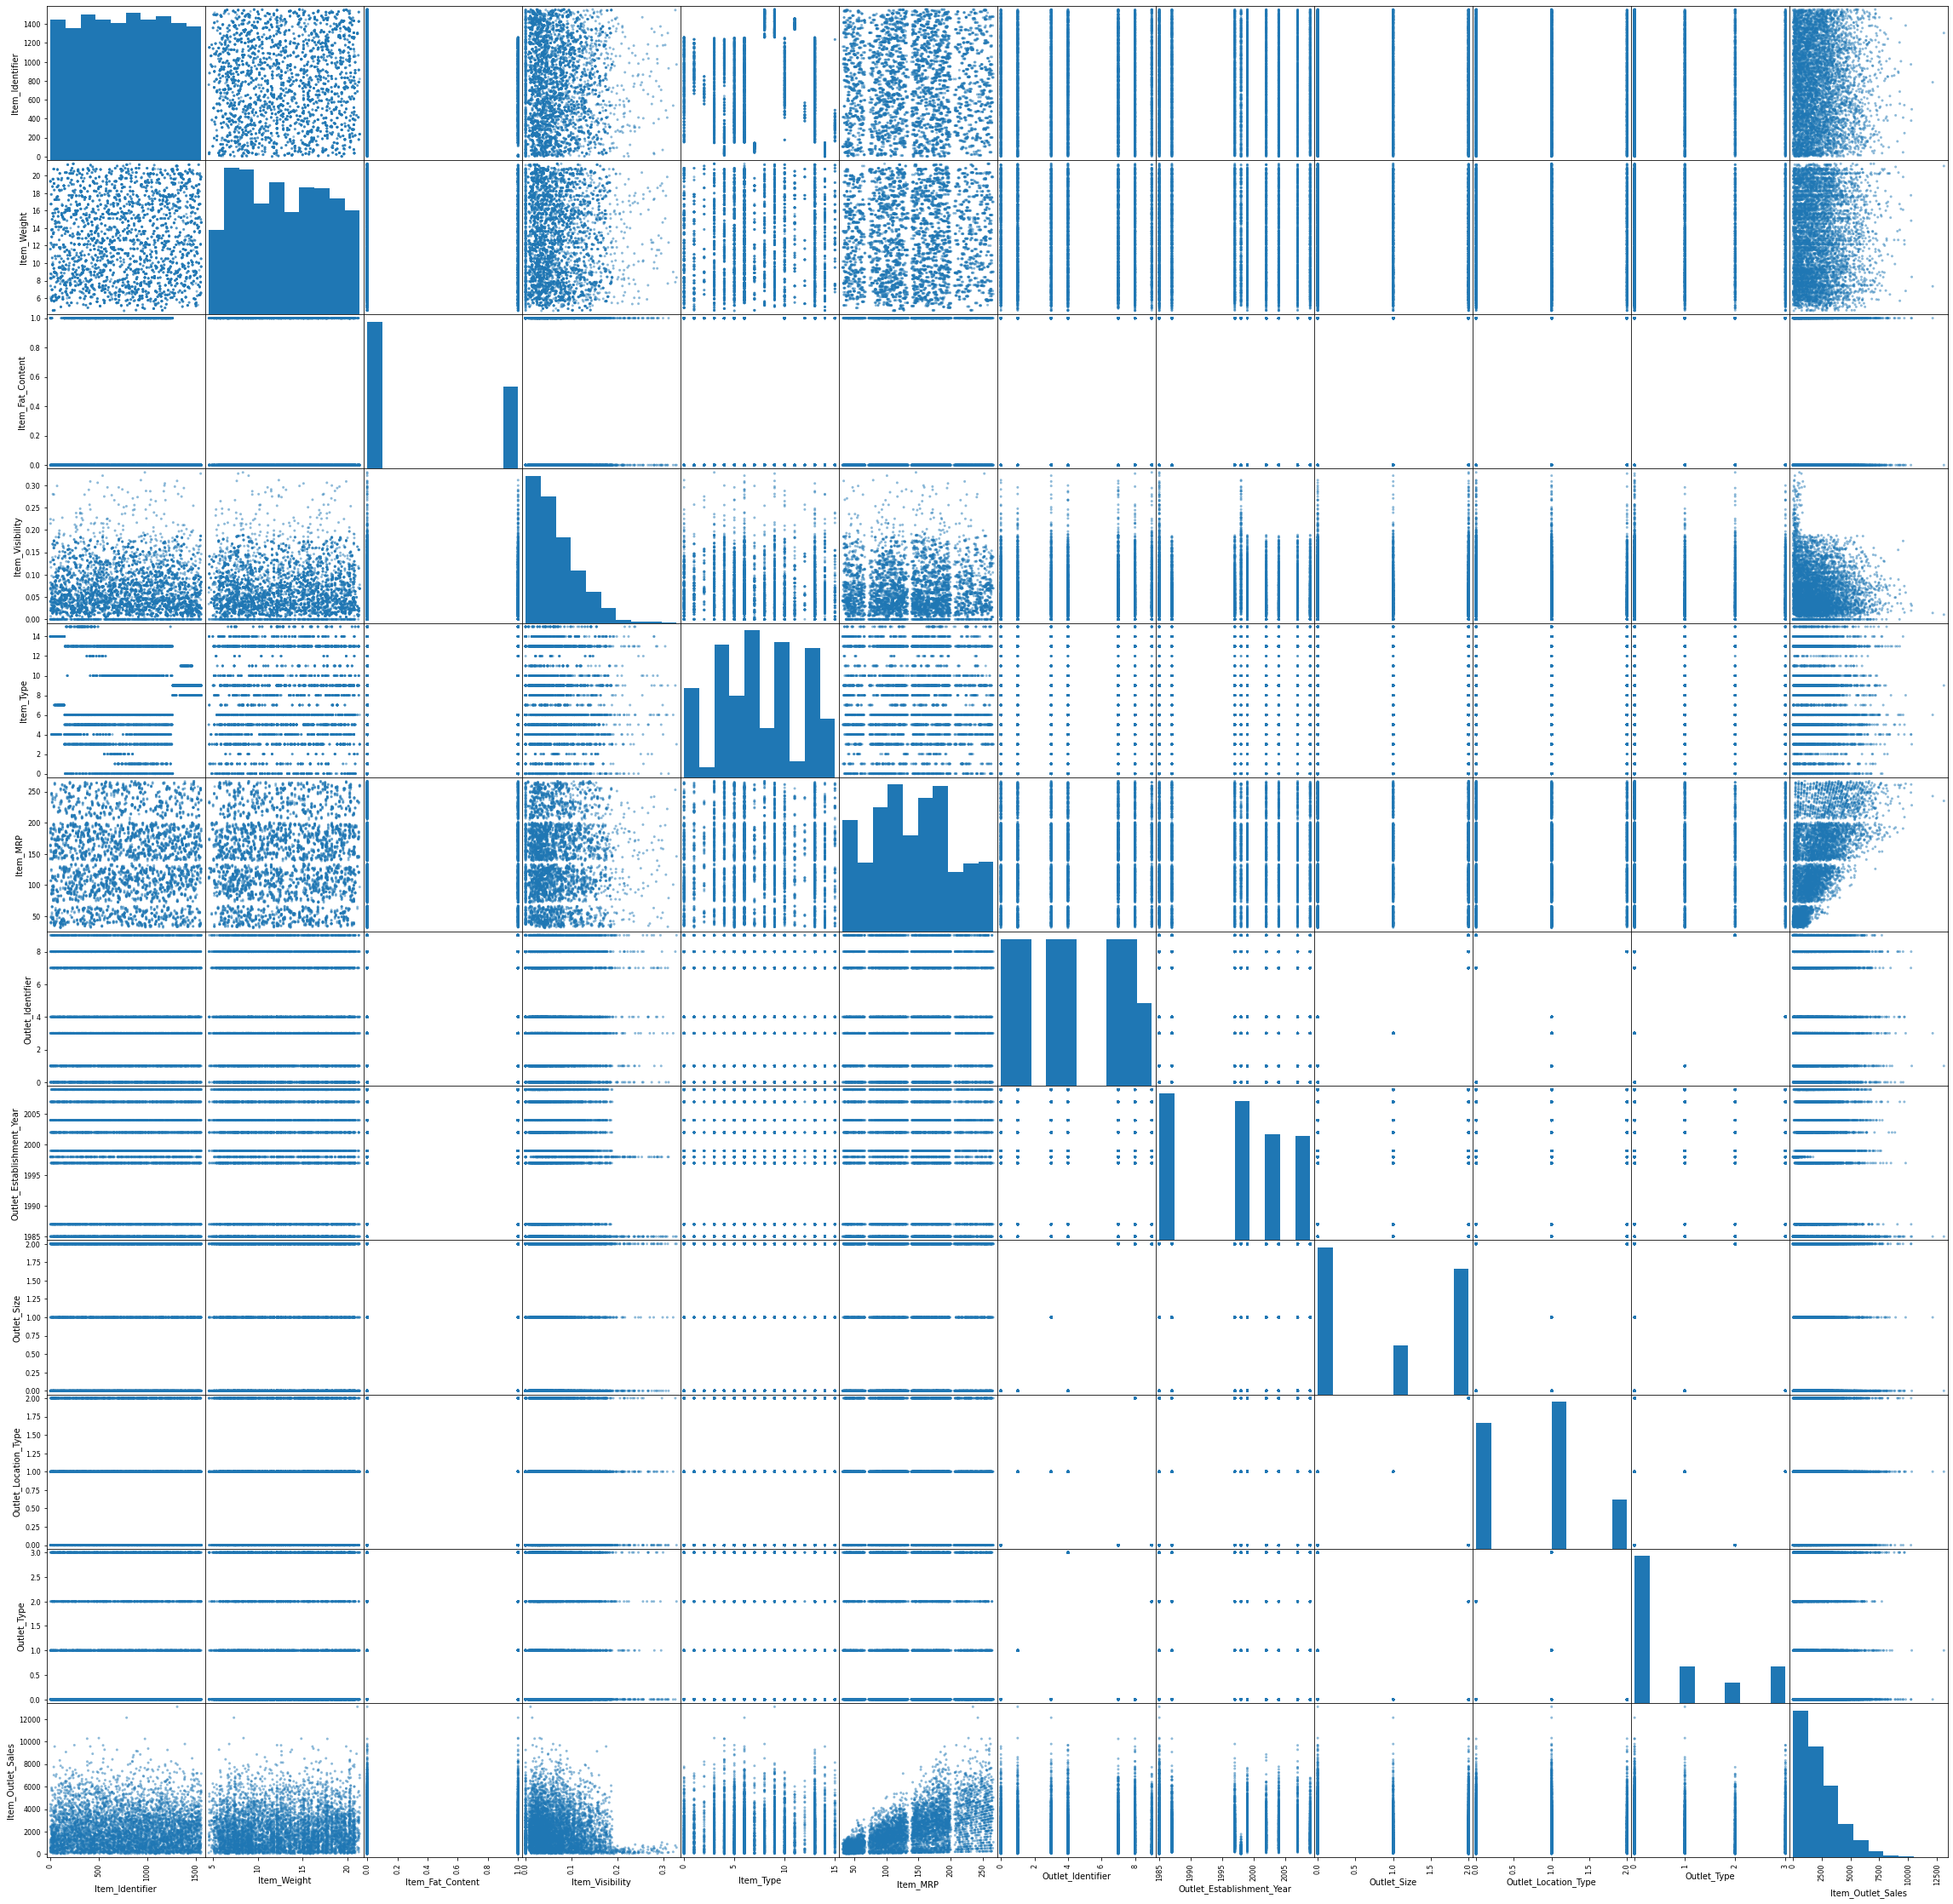

In [20]:
ax = pd.plotting.scatter_matrix(df_copy,figsize=(40,40))

**Preparing data for training to predict values of Outlet_size**

In [21]:
y = df_copy.drop(['Outlet_Identifier','Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Outlet_Type','Item_Outlet_Sales','Outlet_Location_Type','Outlet_Establishment_Year'], axis=1)
features = df_copy.drop(['Outlet_Location_Type','Outlet_Establishment_Year','Outlet_Size','Outlet_Establishment_Year','Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Item_Outlet_Sales'], axis=1)

In [22]:
features.head(2)

,Outlet_Identifier,Outlet_Type
ID,,
0,0.0,0.0
1,1.0,1.0


In [23]:
y.head(2)

,Outlet_Size
ID,
0,0.0
1,0.0


**Spliting data into 70% training set and 30% validation set**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=1)

**Using boost decision tree classification algorithm with suitable tuning of hyperparameters we got 100% accuracy on validation set which is promising**

In [25]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)*100
print ('model accuracy on predicting is: '+str(accuracy)+'%')

model accuracy on predicting is: 100.0%


**Now we will predict missing outlet size then decode the data and merge it back on our data frame**

In [26]:
features_pred = df_Outlet_Size.drop(['Outlet_Location_Type','Outlet_Establishment_Year','Outlet_Size','Outlet_Establishment_Year','Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP','Item_Outlet_Sales'], axis=1)

In [27]:
y_pred = model.predict(features_pred)
df_Outlet_Size['Outlet_Size'] = y_pred

<ipython-input-27-f573156b2936>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Outlet_Size['Outlet_Size'] = y_pred


**Trying to predict Item_Outlet_Sales from these features but sadly we don't have enough to build suitable confident model the cell under is best tunning we can get**

In [28]:
features = df_copy.drop(df.columns.difference(['Item_MRP','Item_Visibility','Outlet_Location_Type','Outlet_Establishment_Year']), 1)
y = df_copy.drop(df.columns.difference(['Item_Outlet_Sales']), 1)

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(features, y, test_size=0.3, random_state=1)

In [30]:
model = XGBRegressor(n_estimators=9000,booster="gbtree", max_depth=1, eta=0.65, subsample=0.356477, colsample_bytree=0.46446582)
model.fit(X_train, y_train)
yhat1 = model.predict(X_train)
yhat2 = model.predict(X_valid)

In [31]:
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

In [32]:
m_train = y_train.shape[0]
m_valid = y_valid.shape[0]
cost_train =  math.sqrt((1/(m_train)) * (np.dot(yhat1.T,yhat1)-2*np.dot(y_train.T,yhat1)+np.dot(y_train.T,y_train))) 
cost_valid =  math.sqrt((1/(m_valid)) * (np.dot(yhat2.T,yhat2)-2*np.dot(y_valid.T,yhat2)+np.dot(y_valid.T,y_valid))) 
print ('training set error : ' + str(cost_train))
print ('validation set error : ' + str(cost_valid ))

training set error : 1084.054709542503
validation set error : 1413.4493936229958


**Our cleaned data frame**

In [33]:
df_copy = pd.concat([df_copy, df_Outlet_Size], sort=False).sort_index()
df_copy.loc[df_copy['Outlet_Size'] > 0 , 'Outlet_Size'] = df_copy['Outlet_Size']+1
df_copy = label_encoder_contain_missing_values().inverse_numeric_to_categorical(table_encoder, df_copy)
def createList(r1, r2):
    return [item for item in range(r1, r2+1)]
df_copy.iloc[createList(-8 , -1)] = df.iloc[createList(-8, -1)]
extract = df_copy['Outlet_Size']
df['Outlet_Size'] = extract
df.head(10)


Inverse Label Encoding, from categorical to numerical completed in Successfully.



,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
ID,,,,,,,,,,,,
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,High,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Medium,Tier 2,Supermarket Type1,1076.5986


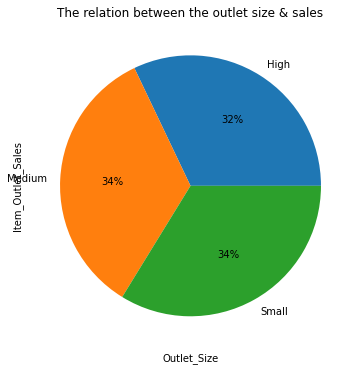

In [34]:
df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().plot(kind='pie',title='The relation between the outlet size & sales', figsize=(13,6), autopct='%0.00f%%')
plt.xlabel('Outlet_Size')
plt.ylabel('Item_Outlet_Sales');

''

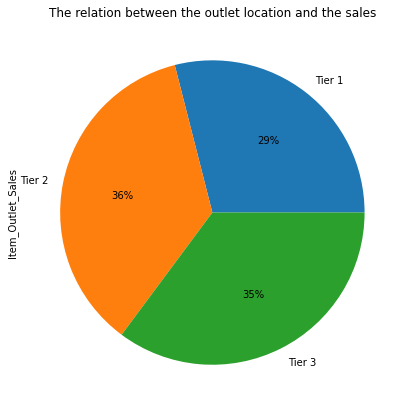

In [35]:
df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().plot(kind='pie',title='The relation between the outlet location and the sales',figsize=(7,7),autopct='%0.0f%%')
;

''

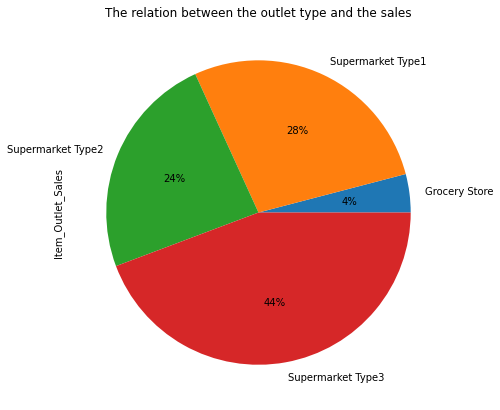

In [37]:
df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().plot(kind='pie',title='The relation between the outlet type and the sales',figsize=(7,7),autopct='%0.0f%%')
;

# Limitations: 
**We weren't able to build a confident model for Item_Outlet_Sales depending on our lack of data**
# conclusions:
**1- Item weight strongly depends on Item identifier so we were able to predict Item weight from it**

**2- Outlet size strongly depends on outlet_Identifier and outlet Type**

**3- we can futurely predict  Item_Outlet_Sales if we proceeded with more data**